In [61]:
import os
from ccdproc import CCDData
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from astropy import units as u
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
from astroquery.gaia import Gaia
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from goodman_pipeline.core import ra_dec_to_deg
from astropy.wcs import WCS
from astropy.wcs.utils import fit_wcs_from_points
from stsci.stimage import xyxymatch

plt.style.use('dark_background')

for _file in sorted(os.listdir('./data/case_1')):
    print(_file)

0347_SN2020uxz-23-10-2020_mask_out.fits
0348_SN2020uxz-23-10-2020_mask_in.fits
0349_SN2020uxz-23-10-2020_mask_out.fits
0350_SN2020uxz-23-10-2020_mask_out.fits
0351_SN2020uxz-23-10-2020_check.fits
default.param


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


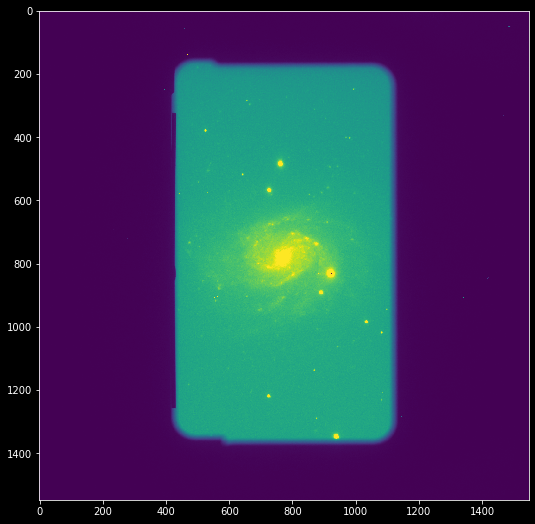

In [62]:
def show_fits(ccd, z1=None, z2=None):
    scale = ZScaleInterval()
    dz1, dz2 = scale.get_limits(ccd)
    if z1 is None:
        z1 = dz1
    else:
        z2 = float(z2)
    if z2 is None:
        z2 = dz2
    else:
        z2 = float(z2)
        
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(ccd.data, clim=(z1, z2))
    
# mask_out_file = 'data/case_1/0347_SN2020uxz-23-10-2020_mask_out.fits'
mask_out_file = 'data/case_1/0350_SN2020uxz-23-10-2020_mask_out.fits'

ccd = CCDData.read(mask_out_file, unit='adu')
show_fits(ccd)

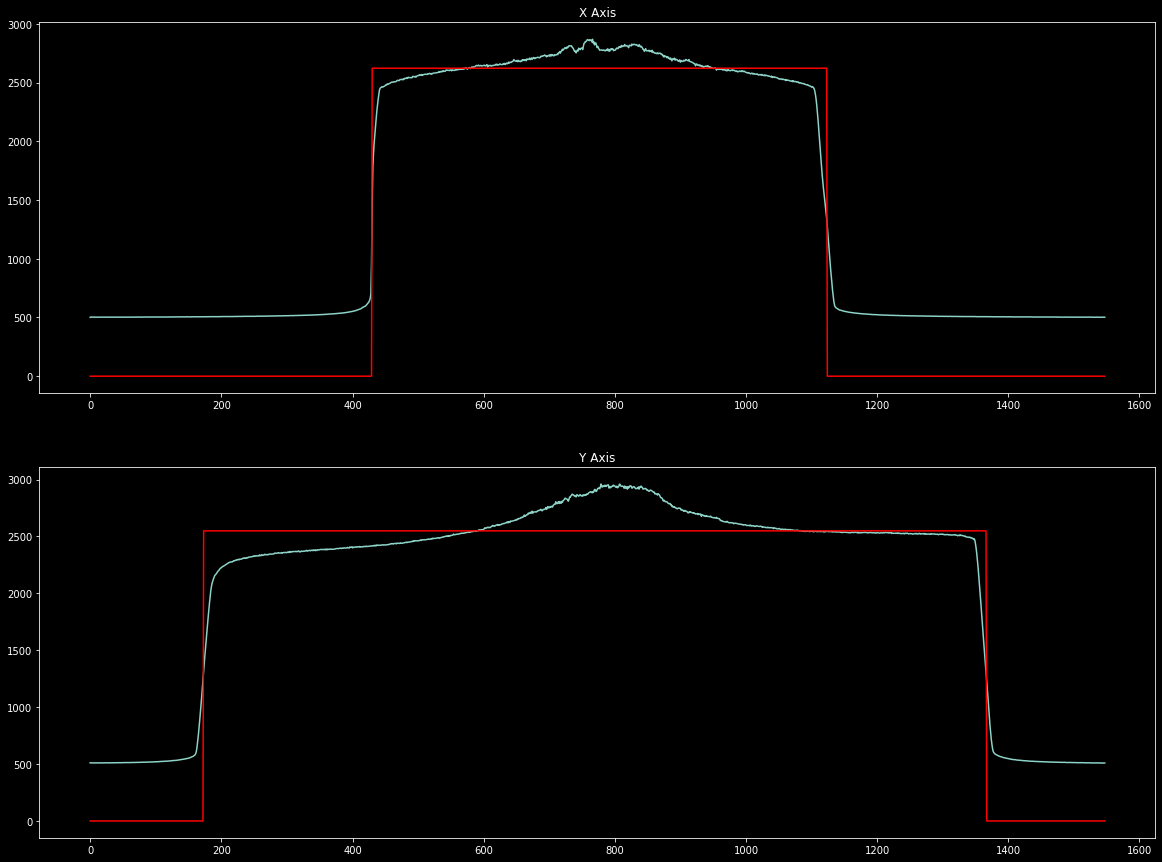

In [63]:

pixel_scale = Angle(0.15, u.arcsec) # arcseconds
x, y = ccd.data.shape
x_median = np.median(ccd.data[int(x/2. - 0.2 * x): int(x/2. + 0.2 * x),:], axis=0)
y_median = np.median(ccd.data[:, int(x/2. - 0.2 * x): int(x/2. + 0.2 * x)], axis=1)

# fit a box model
x_box_model = models.Box1D(amplitude=np.max(x_median), x_0=int(x/2.), width=int(x/2.))
y_box_model = models.Box1D(amplitude=np.max(y_median), x_0=int(y/2.), width=int(y/2.))

box_fitter = fitting.SimplexLSQFitter()

x_box_fitted = box_fitter(x_box_model, range(x), x_median)
y_box_fitted = box_fitter(y_box_model, range(y), y_median)

fig, (ax1, ax2) = plt.subplots(2, 1 ,figsize=(20,15))
ax1.set_title('X Axis')
ax1.plot(x_median)
ax1.plot(x_box_fitted(range(x)), color='r')
ax2.set_title('Y Axis')
ax2.plot(y_median)
ax2.plot(y_box_fitted(range(y)), color='r')
plt.show()

In [64]:
ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])

print(ra_deg, dec_deg)

21.0195875 12.9216125


In [65]:
type(pixel_scale)

astropy.coordinates.angles.Angle

In [66]:
print(x_box_fitted)
print(y_box_fitted)

Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0             width      
    ------------------ ---------------- ----------------
    2623.2694535383357 776.379351497673 694.432621457501
Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0              width       
    ----------------- ----------------- ------------------
    2549.280564661774 769.5797644060467 1194.3699674727877


In [67]:
serial_binning, parallel_binning =  [int(x) for x in ccd.header['CCDSUM'].split()]
print("Serial Binning: {} Paralell Binning: {}".format(serial_binning, parallel_binning))
x_width = x_box_fitted.width.value * (serial_binning * pixel_scale)
y_width = y_box_fitted.width.value * (parallel_binning * pixel_scale)

background_level = (x_box_fitted.amplitude.value + y_box_fitted.amplitude.value) / 2.

Serial Binning: 2 Paralell Binning: 2


In [68]:
w = WCS(naxis=2)
w.wcs.crpix = [x/2., y/2.]
w.wcs.cdelt = np.array([pixel_scale.deg * serial_binning, pixel_scale.deg * parallel_binning])
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.crval = [ra_deg, dec_deg]
w.array_shape = ccd.data.shape
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 21.0195875  12.9216125  
CRPIX : 774.0  774.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 8.333333333333333e-05  8.333333333333333e-05  
NAXIS : 1548  1548

In [69]:
ccd.wcs = w
ccd.write(mask_out_file, overwrite=True)
print(mask_out_file)

# re load file

ccd_new = CCDData.read(mask_out_file, unit='adu')
# ccd_new.header

data/case_1/0350_SN2020uxz-23-10-2020_mask_out.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


1196.0903029890483 518.0 955.0664101215006


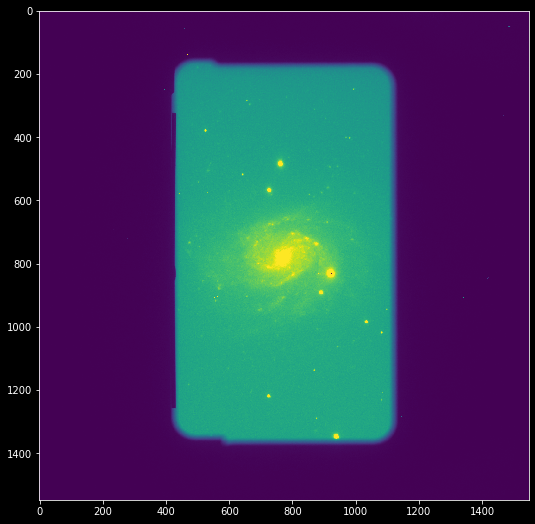

In [70]:
mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)
print(mean, median, std)
show_fits(ccd)


# Find sources using sextractor

In [122]:
import subprocess
from threading import Timer
from goodman_pipeline.core import SaturationValues

saturation_values = SaturationValues()
serial_binning, parallel_binning = [int(x) for x in ccd.header['CCDSUM'].split()]

catalog_name = "sample_ldac.cat" ## OK
catalog_type = "FITS_LDAC"
# catalog_name = "sample.cat" ## OK
# catalog_type = "ASCII_HEAD"
threshold_type = 'ABSOLUTE' ## OK
detection_threshold = 3. * std
pixels_above_threshold = 6
# pixels_below_threshold = 50
seeing_fwhm = ccd.header['SEEING'] # 5 * serial_binning ## OK

# background
background_type='MANUAL' ##  OK
background_value = background_level ## OK

gain = ccd.header['GAIN'] ## OK
pixel_scale = 0.15 * serial_binning # arcsec ## OK
saturation_level = saturation_values.get_saturation_value(ccd)
parameters_file = 'data/case_1/default.param'

# print(ccd.header['CCDSUM'])

sex_command = f"sex {mask_out_file} "\
              f" -CATALOG_NAME {catalog_name}"\
              f" -CATALOG_TYPE {catalog_type}"\
              f" -PARAMETERS_NAME {parameters_file} "\
              f" -DETECT_THRESH {detection_threshold} "\
              f" -DETECT_MINAREA {pixels_above_threshold} "\
              f" -THRESH_TYPE {threshold_type}"\
              f" -FILTER N"\
              f" -GAIN {gain}"\
              f" -BACK_TYPE {background_type}"\
              f" -BACK_VALUE {background_value}"\
              f" -SEEING_FWHM {seeing_fwhm}"\
              f" -PIXEL_SCALE {pixel_scale}"\
              f" -SATUR_LEVEL {saturation_level}"

          # f" -DETECT_MAXAREA {pixels_below_threshold} "\
#               f" -CATALOG_TYPE {catalog_type}"\




In [123]:
def kill_process(process):
    print('Process timed out')
    process.kill()
    
def call_subproces(command):
    print(command)
    try:
        sub_process = subprocess.Popen(command.split(),
                                       stdout=subprocess.PIPE, 
                                       stderr=subprocess.PIPE)
    except OSError as error:
        print(error)
    
    process_timer = Timer(10, kill_process, [sub_process])
    try:
        #     sex_timer.start()
        stdout, stderr = sub_process.communicate()
    finally:
        process_timer.cancel()
    
    if stdout != b'':
        print(stdout)
    if stderr != b'':
        print(stderr.decode('utf-8'))
    
    

In [129]:
call_subproces(sex_command)

sex data/case_1/0350_SN2020uxz-23-10-2020_mask_out.fits  -CATALOG_NAME sample_ldac.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 2865.1992303645015  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.48 -BACK_TYPE MANUAL -BACK_VALUE 2586.275009100055 -SEEING_FWHM 0.613 -PIXEL_SCALE 0.3 -SATUR_LEVEL 69257.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-02-23 at 00:46:21 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 0350_SN2020uxz-23-10-2020_mask_out.fits
----- Measuring from: 0350_SN2020uxz-23-10-2020_mask_out.fits
      "SN2020uxz" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background 

# Match sources using SCAMP and GAIA DR2

In [130]:
astrometric_reference_catalog = "GAIA-DR2"
scamp_command = f"scamp {catalog_name} -ASTREF_CATALOG {astrometric_reference_catalog}"




In [133]:
call_subproces(scamp_command)

scamp sample_ldac.cat -ASTREF_CATALOG GAIA-DR2

> WARNING: scamp.conf not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- SCAMP 2.10.0 started on 2021-02-23 at 00:47:24 with 12 threads

> 
----- 1 input:
> Examining Catalog sample_ldac.cat

> WARNING: FLAGS parameter not found in catalog sample_ldac.cat

sample_ldac.cat:  "SN2020uxz          "  no ext. header   1 set      11 detections

----- 11 detections loaded
> Grouping fields on the sky ...
> Grouping fields: field 1/1, 0 group
> 

----- 1 instrument found for astrometry:

Instrument A1 :
1 extension
FILTER  = 'NO_FILTER'                                                           
QRUNID  =                                                                       

----- 1 instrument found for photometry:

Instrument P1 :
FILTER  = 'NO_FILTER'                                                     

# Load astrometric solution and add it to file

In [134]:
!ls *.head

sample_ldac.head


In [150]:

from astropy.io.fits.header import Header


head_file = open('sample_ldac.head', 'r')
lines = head_file.readlines()
wcs_lines = lines[3:17]
wcs_lines.append(lines[-1])
wcs_string = ''.join(wcs_lines)
print(wcs_string)
# print(lines)
# for l in head_file.readlines():
#     if l.startswith('EQUINOX').l.startswith('CTYPE') or 
#        l.startswith('CUNIT') or l.startswith('CRVAL') or l.startswith('CRPIX') or l.startswith('CD1') or l.startswith('CD2'):
#         pass
#     print(_line)

# head_file_str = head_file.read()

# print(head_file_str)
hdr = Header.fromstring(wcs_string)

# hdr.remove('HISTORY')
hdr

EQUINOX =        2000.00000000 / Mean equinox                                  
RADESYS = 'ICRS    '           / Astrometric system                            
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis             
CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis             
CUNIT1  = 'deg     '           / Axis unit                                     
CUNIT2  = 'deg     '           / Axis unit                                     
CRVAL1  =   2.101644756523E+01 / World coordinate on this axis                 
CRVAL2  =   1.291692517616E+01 / World coordinate on this axis                 
CRPIX1  =   7.740000000000E+02 / Reference pixel on this axis                  
CRPIX2  =   7.740000000000E+02 / Reference pixel on this axis                  
CD1_1   =   8.029918278626E-05 / Linear projection matrix                      
CD1_2   =   7.487406789570E-07 / Linear projection matrix                      
CD2_1   =  -7.487406789570E-07 / Linear 

EQUINOX =        2000.00000000 / Mean equinox                                  

RADESYS = 'ICRS    '           / Astrometric system                            

CTYPE1  = 'RA---TAN'           / WCS projection type for this axis             

CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis             

CUNIT1  = 'deg     '           / Axis unit                                     

CUNIT2  = 'deg     '           / Axis unit                                     

CRVAL1  =   2.101644756523E+01 / World coordinate on this axis                 

CRVAL2  =   1.291692517616E+01 / World coordinate on this axis                 

CRPIX1  =   7.740000000000E+02 / Reference pixel on this axis                  

CRPIX2  =   7.740000000000E+02 / Reference pixel on this axis                  

CD1_1   =   8.029918278626E-05 / Linear projection matrix                      

CD1_2   =   7.487406789570E-07 / Linear projection matrix                      

CD2_1   =  -7.487406789570E-

In [152]:
new_wcs = WCS(hdr)
new_wcs.array_shape = ccd.data.shape
new_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 21.01644756523  12.91692517616  
CRPIX : 774.0  774.0  
CD1_1 CD1_2  : 8.029918278626e-05  7.48740678957e-07  
CD2_1 CD2_2  : -7.48740678957e-07  8.029918278626e-05  
NAXIS : 1548  1548

In [116]:
ccd.wcs = new_wcs
ccd.write('new_file.fits', overwrite=True)



#  Load sources for previsualization

In [57]:
from astropy.io.ascii import SExtractor

sextractor = SExtractor()
catalog = sextractor.read(table=catalog_name)
pd_catalog = catalog.to_pandas()
pd_catalog = pd_catalog.sort_values(by='FLUX_AUTO')
pd_catalog

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 40321: invalid start byte

In [ ]:
positions = np.transpose((pd_catalog['XWIN_IMAGE'], pd_catalog['YWIN_IMAGE']))
source_positions = (pd_catalog['XWIN_IMAGE'], pd_catalog['YWIN_IMAGE'])
# print(positions)
apertures = CircularAperture(positions, r=10.)
scale = ZScaleInterval()
z1, z2 = scale.get_limits(ccd)
# norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title("Detected sources")
ax.imshow(ccd.data, cmap='Greys', origin='lower', clim=(z1, z2),# norm=norm,
           interpolation='nearest')
ax.set_xlim(420, 1100)
ax.set_ylim(200, 1300)
apertures.plot(color='r', lw=1.5, alpha=1)

## Convert pixel coordinates to RA DEC

In [35]:
def physical_to_sky(ccd, sources, pixel_scale_arcsec=0.15):
    """
    
    Args:
        ccd (CCDData): fits file
        sources (pandas.DataFrame): 
        pixel_scale_arcsec (int): Detector's pixel scale in arcseconds
    """
    x_length, y_length = ccd.data.shape
    x_center = x_length / 2.
    y_center = y_length / 2.
    x_binning, y_binning = [int(x) for x in ccd.header['CCDSUM'].split()]
    ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])
    pixel_scale = Angle(pixel_scale_arcsec, u.arcsec)
    sources_ra = []
    sources_dec = []
    for index, source in sources.iterrows():# ['XWIN_IMAGE', 'XWIN_IMAGE']
#         print(dir(source))
#         print(source.__class__)
        source_ra = ra_deg * u.deg - (x_center - source['XWIN_IMAGE']) * x_binning * pixel_scale
        sources_ra.append(source_ra)
        source_dec = dec_deg * u.deg - (y_center - source['YWIN_IMAGE']) * y_binning * pixel_scale
        sources_dec.append(source_dec)
#         print(source[0], source[1], source_ra.deg, source_dec.deg)
        
#     sources.add_columns(cols=[sources_ra, sources_dec], names=['ra', 'dec'])
    sources['ra'] = sources_ra
    sources['dec'] = sources_dec
    return sources
    
ccd_sky_coords = physical_to_sky(ccd=ccd, sources=pd_catalog)
print(ccd_sky_coords)

    XWIN_IMAGE  YWIN_IMAGE  ERRAWIN_IMAGE  ERRBWIN_IMAGE  ERRTHETAWIN_IMAGE  \
2     643.8944    519.7734        0.00653        0.00623             -45.65   
9    1083.0474   1019.1439        0.00702        0.00686             -43.86   
0     526.5215    381.0466        0.00411        0.00388             -51.90   
4    1034.1827    985.5651        0.00280        0.00270             -54.56   
10    726.0752   1220.3093        0.00242        0.00228             -68.17   
5     891.2050    892.5915        0.00206        0.00198             -31.28   
8     727.4890    569.3024        0.00186        0.00178             -40.38   
1     763.1379    485.6272        0.00179        0.00172             -43.87   
3     939.4579   1347.4985        0.00179        0.00169             -76.86   
6     921.7960    832.1511        0.00218        0.00213             -47.32   
7     771.6792    781.3520        0.00654        0.00630             -53.38   

     FLUX_AUTO  FLUXERR_AUTO  CLASS_STAR           

In [479]:
scicoord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(x_width, u.deg)
height = u.Quantity(y_width, u.deg)
print(width, height)
r = Gaia.query_object_async(coordinate=scicoord, width=width, height=height)
r.pprint()

0.057869385121458415 deg 0.0995308306227323 deg
INFO: Query finished. [astroquery.utils.tap.core]
        dist             solution_id     ... epoch_photometry_url
                                         ...                     
-------------------- ------------------- ... --------------------
0.005292847269189498 1635721458409799680 ...                     
0.007983898594830823 1635721458409799680 ...                     
0.013677436319690385 1635721458409799680 ...                     
0.021684277169645168 1635721458409799680 ...                     
0.022210708614576052 1635721458409799680 ...                     
0.024799785337184053 1635721458409799680 ...                     
0.024915832625428597 1635721458409799680 ...                     
 0.02641765564865194 1635721458409799680 ...                     
0.028137712600451642 1635721458409799680 ...                     
 0.02852564397422816 1635721458409799680 ...                     
 0.02971064285656226 1635721458409799680 ...

In [480]:

gaia_sources = SkyCoord(r['ra'], r['dec'])
# gaia_sources = np.transpose((r['ra'], r['dec']))
gaia_sources
# print(dir(r))
# print(r.pprint_all)
# for _col in r.colnames:
#     print(_col)
# print(r.colnames)

<SkyCoord (ICRS): (ra, dec) in deg
    [(21.01623427, 12.91745563), (21.02619948, 12.92633607),
     (21.00693303, 12.92750876), (21.03805578, 12.93371551),
     (21.01244549, 12.90052381), (21.04333665, 12.93053364),
     (21.02465625, 12.94603558), (21.04210277, 12.9363324 ),
     (21.01535035, 12.89378105), (21.00551991, 12.89660318),
     (21.04748583, 12.90962536), (21.01285915, 12.95281034),
     (21.03233284, 12.88689219), (21.0332943 , 12.88703666),
     (21.02528456, 12.95831871), (21.04223124, 12.95343204),
     (21.03047488, 12.96287867), (20.99573051, 12.885547  ),
     (21.00643254, 12.87783295), (21.00388571, 12.96683501),
     (21.03420315, 12.87468405), (21.03259572, 12.97135717)]>

In [481]:
gaia_sources.ra.deg


array([21.01623427, 21.02619948, 21.00693303, 21.03805578, 21.01244549,
       21.04333665, 21.02465625, 21.04210277, 21.01535035, 21.00551991,
       21.04748583, 21.01285915, 21.03233284, 21.0332943 , 21.02528456,
       21.04223124, 21.03047488, 20.99573051, 21.00643254, 21.00388571,
       21.03420315, 21.03259572])

In [482]:
gaia_sources.dec.deg

array([12.91745563, 12.92633607, 12.92750876, 12.93371551, 12.90052381,
       12.93053364, 12.94603558, 12.9363324 , 12.89378105, 12.89660318,
       12.90962536, 12.95281034, 12.88689219, 12.88703666, 12.95831871,
       12.95343204, 12.96287867, 12.885547  , 12.87783295, 12.96683501,
       12.87468405, 12.97135717])

# Plot with WCS information

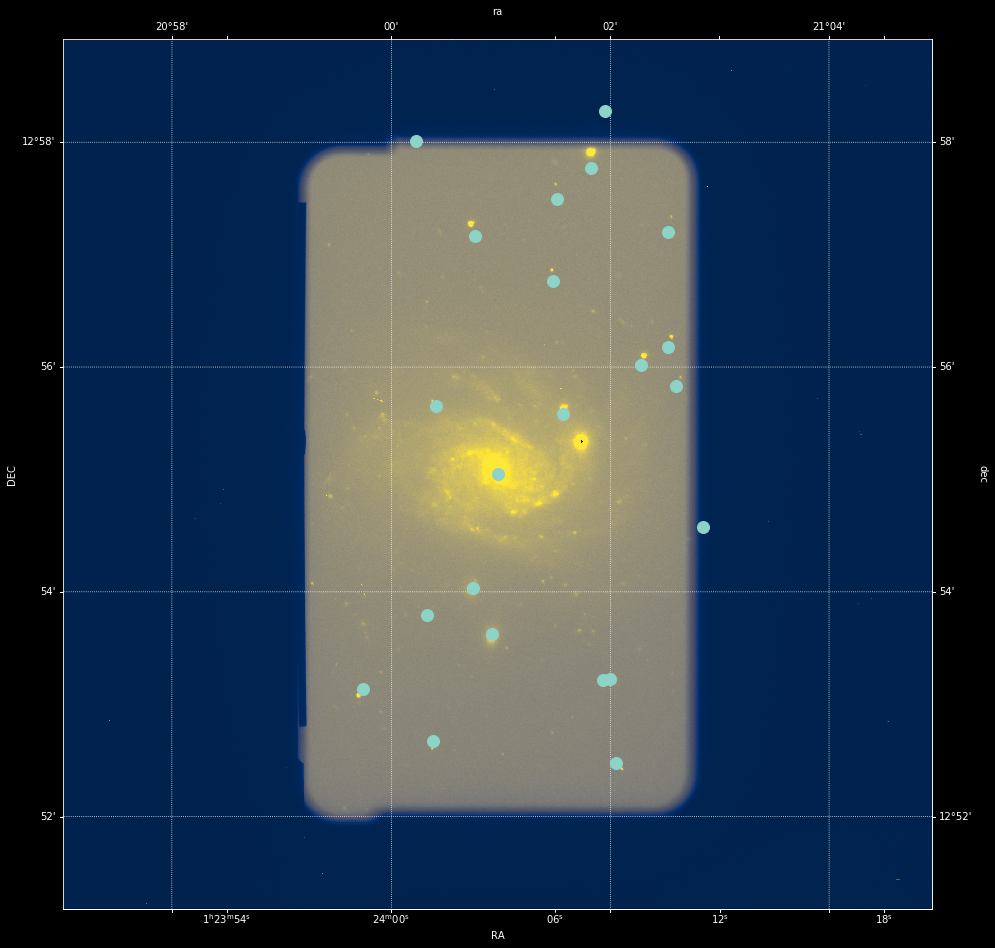

In [483]:
# fig, ax = plt.subplots(figsize=(16,16), subplot_kw={'projection': ccd.wcs})
# scale = ZScaleInterval()

# z1, z2 = scale.get_limits(ccd.data)

# ax.imshow(ccd.data, clim=(z1, z2), origin='lower', cmap='cividis')
fig  = plt.figure(figsize=(16,16))
ax = plt.subplot(projection=ccd_new.wcs)
plt.imshow(ccd_new.data, clim=(z1, z2), origin='lower', cmap='cividis')
ax.plot(gaia_sources.ra.deg, gaia_sources.dec.deg, 'o', markersize=12, transform=ax.get_transform('icrs'))
plt.xlabel(r'RA')
plt.ylabel(r'DEC')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

In [ ]:
# print(np.array(sources['xcentroid'].data))
source_positions = (sources['xcentroid'].data, sources['ycentroid'].data)
print(source_positions)

# wcs = fit_wcs_from_points(xy=source_positions, world_coords=gaia_sources)

In [ ]:

gaia_positions = np.transpose((r['ra'], r['dec']))

ccd_positions = np.transpose(ccd_sky_coords)
print(ccd_sky_coords)

field = SkyCoord(ra=ccd_sky_coords['ra'] *u.degree, dec=ccd_sky_coords['dec'] * u.degree)
gaia_catalog = SkyCoord(ra=gaia_sources.ra, dec=gaia_sources.dec)

# idx, d2d, d3d = field.match_to_catalog_sky(gaia_catalog)
idx, d2d, d3d = match_coordinates_sky(field, gaia_catalog)
print(idx)
print(d2d)
print(d3d)
matches = gaia_catalog[idx]
print(matches)
new_ra, new_dec = field.spherical_offsets_to(matches)
print(new_ra.deg)
print(field.ra.deg)
# print((matches.separation_3d(field) == d3d).all())
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.set_title('GAIA Sources')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.plot(gaia_sources.ra, gaia_sources.dec, 'o', markersize=12)
ax1.plot(field.ra.deg + new_ra.deg , field.dec.deg + new_dec.deg, '1', color='red', markersize=12)
# ax1.plot(new_ra, new_dec, 'o', color='magenta', markersize=12)
# sub_data = [int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.):int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.),int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.):int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.)]
ax2.imshow(ccd.data, origin='lower', norm=norm,
           interpolation='nearest')
ax2.set_ylim(int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.), int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.))
ax2.set_xlim(int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.), int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.))
apertures.plot(color='red', lw=3)
# apertures = CircularAperture(gaia_positions, r=5.)
# apertures.plot(color='white', lw=1.5, alpha=0.5)

In [ ]:
print(gaia_sources)

In [ ]:
print(dir(apertures))
print(apertures.positions)